In [ ]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast

In [ ]:
path = '/content/drive/MyDrive/Physionet/ptb-xl/'
excel = '/content/drive/MyDrive/Physionet/ptb-xl/ptbxl_database.csv'

In [ ]:
import pandas as pd
import numpy as np
import ast
import wfdb
from torch.utils.data import Dataset
from torchvision import transforms

class Custom_class(Dataset):
    def __init__(self, excelfile, path, num_data, transform=None, test_flag=False):
        self.dat = pd.read_csv(excelfile)
        self.col = self.dat['filename_hr']
        self.data = self.col[:num_data]
        self.label = self.dat['scp_codes']
        self.labels = self.label[:num_data]
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.test_flag = test_flag

        if self.test_flag:
            self.indices = [idx for idx in range(self.num_data) if self.strat_fold[idx] == 10]
        else:
            self.indices = [idx for idx in range(self.num_data) if self.strat_fold[idx] != 10]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        y, _ = wfdb.rdsamp(self.path + self.data[idx])  # Use channel 0
        y = y.astype(np.float32)
        y = np.transpose(y)
        scp_code_dict = ast.literal_eval(self.labels[idx])

        # Check if the first key is 'NORM' and assign the label accordingly
        first_key = next(iter(scp_code_dict))
        label = 0 if first_key == 'NORM' else 1

        if self.transform:
            y = self.transform(y)

        return y[0,:,:], label

# Example usage
transform = transforms.Compose([
    transforms.ToTensor(),
])

# For training data
train_dataset = Custom_class(excel, path, num_data=2000, transform=transform, test_flag=False)

# For test data
test_dataset = Custom_class(excel, path, num_data=5000, transform=transform, test_flag=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, T = x.size()
        query = self.query(x).view(batch_size, -1, T).permute(0, 2, 1)  # B x T x C'
        key = self.key(x).view(batch_size, -1, T)  # B x C' x T
        value = self.value(x).view(batch_size, -1, T)  # B x C x T

        attention = torch.bmm(query, key)  # B x T x T
        attention = F.softmax(attention, dim=-1)  # B x T x T

        out = torch.bmm(value, attention.permute(0, 2, 1))  # B x C x T
        out = self.gamma * out + x
        return out

# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding='same')
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += shortcut
        x = F.relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding='same')
        self.bn3 = nn.BatchNorm1d(out_channels)

        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding='same')
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x += shortcut
        x = F.relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=27):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 64, 3)
        self.layer2 = self._make_layer(ResBlock2, 64, 128, 4)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 6)
        self.layer4 = self._make_layer(ResBlock2, 256, 512, 3)

        self.attention = SelfAttention(512)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.attention(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=2)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 25
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0




for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)


    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Deep copy the model if the current accuracy is the best so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    scheduler.step()

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), "best_model.pth")

print(f"Training complete. Best accuracy: {best_acc:.4f}")


Epoch 0/24, Loss: 0.6778, Accuracy: 0.5759
Epoch 1/24, Loss: 0.6481, Accuracy: 0.6854
Epoch 2/24, Loss: 0.6248, Accuracy: 0.7129
Epoch 3/24, Loss: 0.6033, Accuracy: 0.7295
Epoch 4/24, Loss: 0.5839, Accuracy: 0.7410
Epoch 5/24, Loss: 0.5683, Accuracy: 0.7547
Epoch 6/24, Loss: 0.5564, Accuracy: 0.7628
Epoch 7/24, Loss: 0.5432, Accuracy: 0.7656
Epoch 8/24, Loss: 0.5351, Accuracy: 0.7920
Epoch 9/24, Loss: 0.5349, Accuracy: 0.7903
Epoch 10/24, Loss: 0.5361, Accuracy: 0.7851
Epoch 11/24, Loss: 0.5259, Accuracy: 0.7943
Epoch 12/24, Loss: 0.5227, Accuracy: 0.8029
Epoch 13/24, Loss: 0.5244, Accuracy: 0.8057
Epoch 14/24, Loss: 0.5172, Accuracy: 0.8120
Epoch 15/24, Loss: 0.5218, Accuracy: 0.7977
Epoch 16/24, Loss: 0.5195, Accuracy: 0.7966
Epoch 17/24, Loss: 0.5168, Accuracy: 0.8097
Epoch 18/24, Loss: 0.5164, Accuracy: 0.8063
Epoch 19/24, Loss: 0.5187, Accuracy: 0.8052
Epoch 20/24, Loss: 0.5180, Accuracy: 0.8057
Epoch 21/24, Loss: 0.5141, Accuracy: 0.8132
Epoch 22/24, Loss: 0.5180, Accuracy: 0.806

In [ ]:
test_dataloder = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, confusion_matrix = test_model(model, test_dataloder)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)


Accuracy: 0.695024077046549
Confusion Matrix:
[[259  50]
 [140 174]]


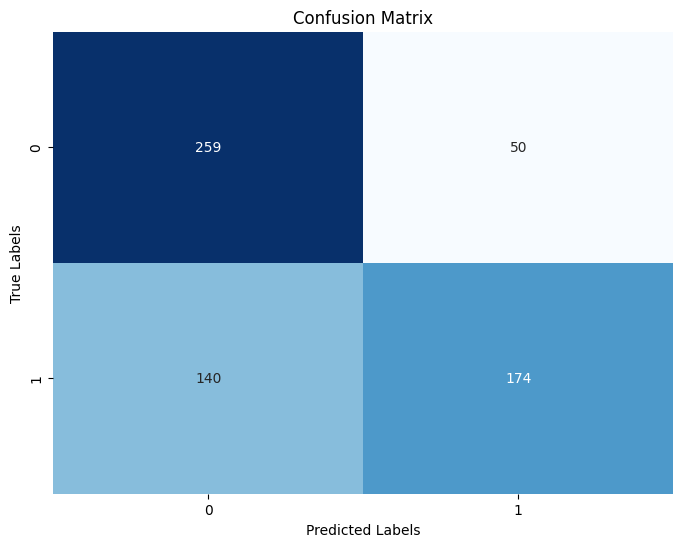

In [ ]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()